# Frequency Accuracy test
- https://www.silabs.com/documents/public/data-sheets/Si5351-B.pdf
- https://www.silabs.com/documents/public/application-notes/AN619.pdf
- https://www.silabs.com/content/usergenerated/asi/cloud/attachments/siliconlabs/en/community/groups/timing/knowledge-base/jcr:content/content/primary/blog/modifying_the_feedba-K8Pv/311668.pdf

In [1]:
import os, sys

def gen_relative_path(target_path): 
    
    def del_same_parents(target_path, current_path):
        if len(target_path) * len(current_path) > 0:
            if target_path[0] == current_path[0]:
                target_path.pop(0)
                current_path.pop(0)
                del_same_parents(target_path, current_path)
            
    current_path = os.getcwd().replace('\\', '/').split('/')
    target_path = target_path.replace('\\', '/').split('/')
    del_same_parents(target_path, current_path)
    
    return ['..'] * len(current_path) + target_path


def append_source_relative_path(source_relative_path):
    sys.path.append(os.sep.join(source_relative_path))

In [2]:
# paths = ['']
# paths = [gen_relative_path(p) for p in paths]
# print(paths)

In [3]:
paths = [['..', '..', '..', '..', '..', '..', '..', '已完成', 'Bridges', 'bitbucket', 'github', 'codes'], 
         ['..', '..', '..', '..', '..', '..', 'Utilities', 'bitbucket', 'github', 'codes'],
         ['..', '..', '..', 'codes']]

for path in paths:
    append_source_relative_path(path)

In [4]:
%pylab inline

from clock_generators.si535x.si5351 import Si5351A_B_GT 
from utilities.adapters import peripherals

Populating the interactive namespace from numpy and matplotlib


## Debug mode?

In [5]:
cls = Si5351A_B_GT

cls.DEBUG_MODE_SHOW_BUS_DATA = False         # whether to show bus data. 
cls.DEBUG_MODE_PRINT_REGISTER = False        # whether to print registers. 

## Generators

In [6]:
with_hardware_device = False

if with_hardware_device:
    _i2c = peripherals.I2C.get_Ftdi_i2c() 
    
else:
    _i2c =  None  # using None for testing without actual hardware device.

si = cls(_i2c)  

****** Virtual device. Data may not be real ! ******


In [7]:
si.enable(True)

In [8]:
si.enable(False)

In [9]:
clk = si.clocks[0]
pll = si.plls['A']
ms = si.multisynths[0]

In [10]:
clk.enable(True)

## Frequency Accuracy test

### Xtal Frequency

In [11]:
freq_pfd = 25e6

### Minimum Clock Frequency

In [12]:
freq_min = freq_pfd * 24 / 2048 / 128
freq_min 

2288.818359375

### set_freq function

In [13]:
def set_freq(freq, debug = True): 
    
    clk.set_frequency(freq)   
    freq_calculated = pll.freq / ms.divider / clk.divider
    desired_ms_divider = 25e6 * pll.divider / clk.divider / freq    
    err = ms.divider - desired_ms_divider
    ms_divider_match = ms.divider == desired_ms_divider
    
    if debug:
        print('freq:', freq)
        print()    

        print('pll.divider', pll.divider)
        print('pll.freq', pll.freq)
        print()

        print('ms.divider', ms.divider)
        print('ms.is_in_integer_mode', ms.is_in_integer_mode) 
        print('ms.is_divided_by_4', ms.is_divided_by_4)
        print('ms.freq', ms.freq)
        print()

        print('clk.divider', clk.divider)
        print('clk.freq', clk.freq)
        print('freq_calculated', freq_calculated)
        print('freq_calculated == freq' , freq_calculated == freq)
        print()  
        
    return freq, err, desired_ms_divider, ms.divider

## Set Frequency

In [14]:
clk.enable(False)

In [15]:
clk.enable(True)

In [16]:
freq_min = 2289
freq_max = 225e6

In [17]:
freq = 2289  # minimum frequency
# freq = 5.4e6
freq = 225e6 # maximum frequency
# freq = 112.4e6
# freq = 113.4e6 
# freq = 149.4e6
# freq = 150.4e6 
# freq = 97.7e6  # Radio station
freq = 90e6
freq = 25.2e6
# freq = 50.6e6

set_freq(freq)

freq: 25200000.0

pll.divider 36
pll.freq 900000000

ms.divider 35.714285714285715
ms.is_in_integer_mode False
ms.is_divided_by_4 False
ms.freq 25200000

clk.divider 1
clk.freq 25200000
freq_calculated 25200000.0
freq_calculated == freq True



(25200000.0, 0.0, 35.714285714285715, 35.714285714285715)

## Sweep and test a frequency range

In [18]:
def sweep(freq_start = freq_min, freq_end = freq_max, n_freqs = 5000 , sweep_type = 'linear'):

    if sweep_type == 'linear':
        start = freq_start
        step = (freq_end - freq_start) / n_freqs
        freqs = [(start + i * step) for i in range(n_freqs)]
    else:
        start = math.log10(freq_start)
        step = math.log10(freq_end / freq_start) / n_freqs
        freqs = [10 ** (start + i * step) for i in range(n_freqs)]
    
    return freqs

# freqs = sweep(sweep_type = 'log')
freqs = sweep(sweep_type = 'linear')

In [19]:
validated_result = np.array([set_freq(f, debug = False) for f in freqs]).T

Failed in setting multisynth 0 to freq 2289.0 x 1 = 2289.0.
Failed in setting multisynth 0 to freq 2289.0 x 2 = 4578.0.
Failed in setting multisynth 0 to freq 2289.0 x 4 = 9156.0.
Failed in setting multisynth 0 to freq 2289.0 x 8 = 18312.0.
Failed in setting multisynth 0 to freq 2289.0 x 16 = 36624.0.
Failed in setting multisynth 0 to freq 2289.0 x 32 = 73248.0.
Failed in setting multisynth 0 to freq 2289.0 x 64 = 146496.0.
Failed in setting multisynth 0 to freq 47288.5422 x 1 = 47288.5422.
Failed in setting multisynth 0 to freq 47288.5422 x 2 = 94577.0844.
Failed in setting multisynth 0 to freq 47288.5422 x 4 = 189154.1688.
Failed in setting multisynth 0 to freq 92288.0844 x 1 = 92288.0844.
Failed in setting multisynth 0 to freq 92288.0844 x 2 = 184576.1688.
Failed in setting multisynth 0 to freq 137287.62660000002 x 1 = 137287.62660000002.
Failed in setting multisynth 0 to freq 137287.62660000002 x 2 = 274575.25320000004.
Failed in setting multisynth 0 to freq 182287.1688 x 1 = 18228

In [20]:
freqs_tested = validated_result[0]
errors = validated_result[1]

In [21]:
freqs_tested

array([2.28900000e+03, 4.72885422e+04, 9.22880844e+04, ...,
       2.24865001e+08, 2.24910001e+08, 2.24955000e+08])

## Frequency vs. Errors

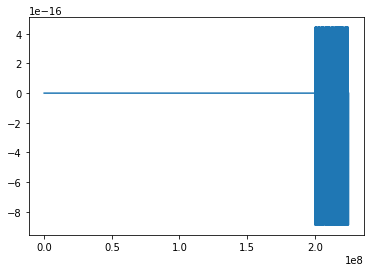

In [22]:
plt.plot(freqs_tested, errors);